In [1]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 3 for the experiment.


In [2]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import keras as keras
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2024-04-27 11:52:38.131027: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Prepare Training Data:
path_to_X = "../Normalised/X.npy"
path_to_Y = "../Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [4]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full seq_model model
    seq_model_outputs = decoder_model(encoder_lstm)
    seq_model = Model(encoder_inputs, seq_model_outputs)
    
    # Compile the model
    seq_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    seq_model.summary()
    return seq_model

In [5]:
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:1'):
        save_path = "./Saved_Models_Data/P50_U40_OA/"
        seq_model = createModel(40,'adam')
        early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
        mc = ModelCheckpoint(save_path+"best_enc_dec_3.h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        history = seq_model.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history_3.json','w') as file:
            json.dump(history.history, file)
else:
    print("No GPU available.")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-27 11:52:45.230558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 model_1 (Functional)        (None, 81, 1)             13001     
                                                                 
Total params: 19721 (77.04 KB)
Trainable params: 19721 (77.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2024-04-27 11:52:49.638390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-27 11:52:49.773285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-27 11:52:49.773719: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa5f6193c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-27 11:52:49.773737: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-27 11:52:49.777358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-27 11:52:49.887599: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1241/1244 [============================>.] - ETA: 0s - loss: 0.1173 - mae: 0.2413
Epoch 1: val_loss improved from inf to 0.12133, saving model to ./Saved_Models_Data/P50_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 17s 11ms/step - loss: 0.1173 - mae: 0.2412 - val_loss: 0.1213 - val_mae: 0.2317
Epoch 2/200
  18/1244 [..............................] - ETA: 12s - loss: 0.1040 - mae: 0.2154

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1242/1244 [============================>.] - ETA: 0s - loss: 0.0941 - mae: 0.1861
Epoch 2: val_loss improved from 0.12133 to 0.09396, saving model to ./Saved_Models_Data/P50_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0941 - mae: 0.1861 - val_loss: 0.0940 - val_mae: 0.1935
Epoch 3/200
1244/1244 [==============================] - ETA: 0s - loss: 0.0884 - mae: 0.1802
Epoch 3: val_loss improved from 0.09396 to 0.07722, saving model to ./Saved_Models_Data/P50_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0884 - mae: 0.1802 - val_loss: 0.0772 - val_mae: 0.1580
Epoch 4/200
1241/1244 [============================>.] - ETA: 0s - loss: 0.0769 - mae: 0.1522
Epoch 4: val_loss improved from 0.07722 to 0.07368, saving model to ./Saved_Models_Data/P50_U40_OA/best_enc_dec_3.h5
1244/1244 [==============================] - 14s 11ms/step - loss: 0.0769 - mae: 0.1521 - val_loss: 0.0737 - val_mae: 0.1448
Epoc

In [6]:
import numpy as np
import json
import matplotlib.pyplot as plt

save_path = "./Saved_Models_Data/P50_U40_OA/"
f = open(save_path+"history_3.json")
history = json.load(f)
print(len(history['loss']))

153


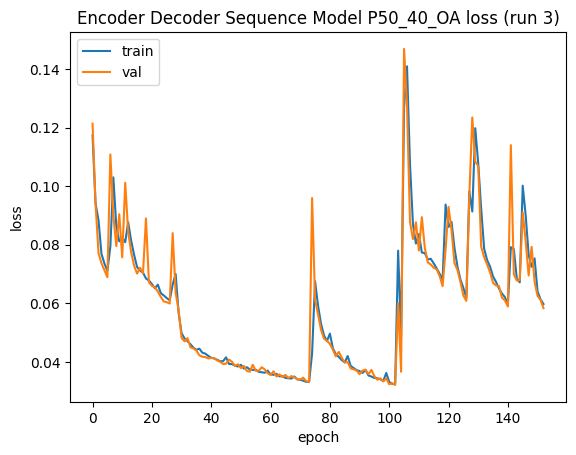

In [7]:
# summarize history for loss
mod_name = "P50_40_OA"
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Encoder Decoder Sequence Model '+mod_name+' loss (run 3)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
#Evaluate the saved best model:
from keras.models import load_model
saved_model = load_model(save_path+"best_enc_dec_3.h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 2s 5ms/step - loss: 0.0321 - mae: 0.0611
Mean Squared Error:  0.032064687460660934
Mean Absolute Error:  0.06114450469613075
Root Mean Squared Error (RMSE):  0.17906615386683475


In [9]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions_3.npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth_3.npy", Y_test)

389/389 [==============================] - 2s 4ms/step


In [10]:
#print some samples
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path +"ground-truth_3.npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.04987112432718277
Index 1 Ground truth: 0 Predicted: 0.2585301101207733
Index 2 Ground truth: 1 Predicted: 0.5964364409446716
Index 3 Ground truth: 0 Predicted: 2.306127726114937e-06
Index 4 Ground truth: 0 Predicted: 5.4446613884095996e-11
Index 5 Ground truth: 0 Predicted: 3.282586062778453e-14
Index 6 Ground truth: 0 Predicted: 1.710519340102426e-14
Index 7 Ground truth: 0 Predicted: 2.0614630835691372e-10
Index 8 Ground truth: 0 Predicted: 6.175192538648844e-05
Index 9 Ground truth: 0 Predicted: 5.029482053942047e-05
Index 10 Ground truth: 0 Predicted: 4.0055316702369836e-11
Index 11 Ground truth: 0 Predicted: 7.856100318892612e-12
Index 12 Ground truth: 0 Predicted: 0.00016547359700780362
Index 13 Ground truth: 1 Predicted: 0.993876039981842
Index 14 Ground truth: 0 Predicted: 0.0010754188988357782
Index 15 Ground truth: 0 Predicted: 5.2007131046138966e-08
Index 16 Ground truth: 0 Predicted: 9.635157766751945e-

In [11]:
#Can convert to Benesh version for predictions using a threshold here (0.5)
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh_3.npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [12]:
#save the error array
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr_3.npy",err_arr)

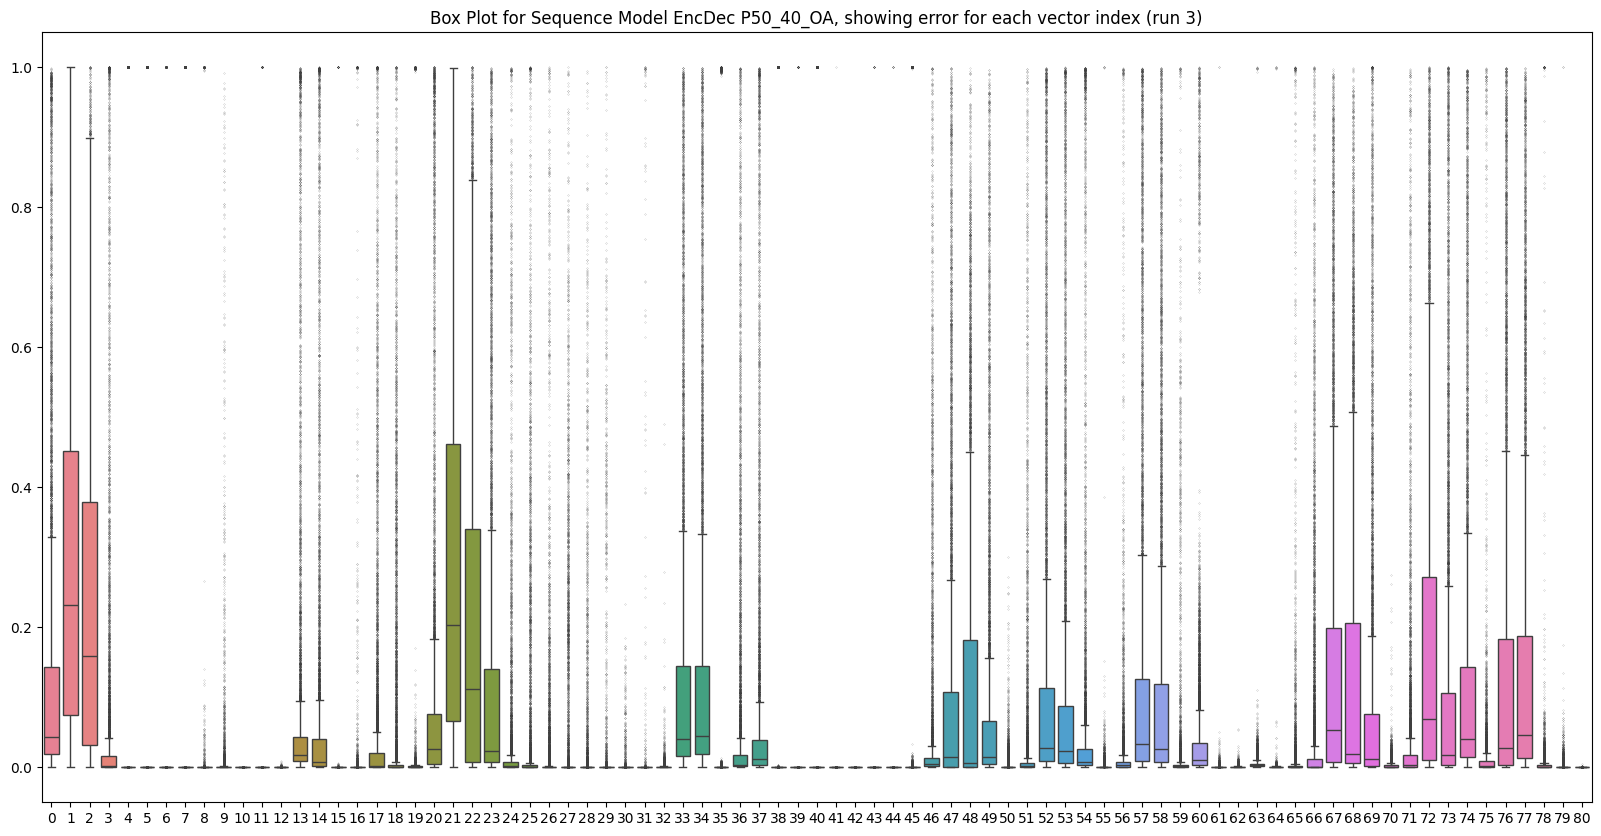

In [13]:
import seaborn as sns
err_arr = np.load(save_path+"err_arr_3.npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for Sequence Model EncDec '+mod_name+', showing error for each vector index (run 3)')
plt.show()

In [14]:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    global overall_MAPE
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples*100 # Multiply by 100 to get the percentage
    print("OVERALL MAPE %: ", overall_MAPE)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.04984739 0.05820719 0.06110444 0.06844448 0.08054758 0.04570569
 0.13072655 0.14982459 0.07093986 0.03942701]
OVERALL MAPE %:  6.11445046333898


In [15]:
from sklearn.metrics import r2_score
y_pred = np.load(save_path+"predictions_3.npy")
y_true = np.load(save_path+"ground-truth_3.npy")

In [16]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.80040621 0.69807608 0.82146393 ... 0.82695098 0.77990478 0.79592758]
Overall R-squared value: 0.7459220937847386


In [17]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.60494786 0.59008428 0.61535237 ... 0.60643422 0.60048878 0.6034615 ]
Overall Spearman correlation coefficient: 0.5759602251256842


In [18]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.89475965 0.83739287 0.90875761 ... 0.91037252 0.88315947 0.8941994 ]
12433
Overall Pearson correlation coefficient: 0.8615633944360569


In [19]:
from sklearn.metrics import matthews_corrcoef #calculated using the converted 0.5 threshold benesh vector
y_pred = np.load(save_path + "y_pred_benesh_3.npy")
y_true = np.load(save_path + "ground-truth_3.npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.8270332136041936


In [20]:
#Save boxplot stats
import numpy as np
save_path = "./Saved_Models_Data/P50_U40_OA/"

np.set_printoptions(suppress=True) # Disable scientific notation
filename = "err_arr_3.npy"

err = np.load(save_path+filename)
print(len(err))

stats = np.empty(shape = (0,5))
n_indices = len(err[0]) # should be 81
print(n_indices)

for i in range(n_indices):
    i_stats = np.percentile(err[:, i], [0, 25, 50, 75, 100]) # = [Min, Q1, Med, Q3, Max]
    stats = np.vstack([stats, i_stats]) # Add row to numpy stats object 
    print("index: {}".format(i), i_stats)

# print(stats)
out_filename = "boxplot_stats_3.csv"

np.savetxt(save_path+out_filename, stats, delimiter = ',', fmt='%f')

# Values
values = [best_eval[1],
	mse_value,
	rmse_value,
	overall_MAPE,
	overall_r2,
	overall_spearman_corr,
	overall_pearson_corr,
	overall_mcc]

# Labels
labels = ["MAE",
	"MSE",
	"RMSE",
	"MAPE",
	"R2",
	"Spearman",
	"Pearson",
	"MCC"]

# now we print to txt file 
with open(f"Metrics/metrics_{mod_name}.csv", 'w') as f:
	f.write('\n'.join(map(lambda a, b : a + "," + str(b), labels, values)))

12433
81
index: 0 [0.00016823 0.01927549 0.04342269 0.14313234 0.99856184]
index: 1 [0.00000364 0.07490145 0.23234299 0.45231616 0.99992847]
index: 2 [0.00000291 0.03188265 0.15896177 0.37924939 0.99998976]
index: 3 [0.00000007 0.00006546 0.00150367 0.01678625 0.99999819]
index: 4 [0.         0.         0.         0.00000001 1.        ]
index: 5 [0. 0. 0. 0. 1.]
index: 6 [0. 0. 0. 0. 1.]
index: 7 [0. 0. 0. 0. 1.]
index: 8 [0.00000002 0.00000815 0.00003014 0.00008287 0.99999714]
index: 9 [0.00000244 0.00006279 0.0001487  0.00069378 0.99146403]
index: 10 [0.         0.         0.         0.         0.00000215]
index: 11 [0. 0. 0. 0. 1.]
index: 12 [0.         0.00000034 0.00000484 0.00003288 0.0087217 ]
index: 13 [0.00002227 0.00852829 0.01729828 0.04274046 0.99963115]
index: 14 [0.00000233 0.00212034 0.00778569 0.03981117 0.9999012 ]
index: 15 [0.         0.         0.00000002 0.00000006 1.        ]
index: 16 [0.         0.00000002 0.00000046 0.00004204 1.        ]
index: 17 [0.00000368 